In [1]:
import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs

In [2]:
pl.rcParams['figure.facecolor']='w'

In [3]:
from spectral_cube import SpectralCube

In [4]:
from pvextractor import extract_pv_slice, Path

In [5]:
cube = SpectralCube.read('http://www.astropy.org/astropy-data/l1448/l1448_13co.fits')

In [6]:
cube

SpectralCube with shape=(53, 105, 105):
 n_x:    105  type_x: RA---SFL  unit_x: deg    range:    50.924417 deg:   51.740103 deg
 n_y:    105  type_y: DEC--SFL  unit_y: deg    range:    30.301945 deg:   30.966389 deg
 n_s:     53  type_s: VOPT      unit_s: m / s  range:     2528.195 m / s:    5982.223 m / s

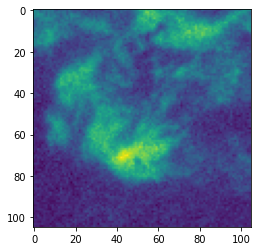

In [7]:
cube[25].quicklook()

First we create an extraction path:

In [8]:
path = Path([(20,20), (40,40), (60,20)])

Then we can overplot it on our figure, now with WCS shown:

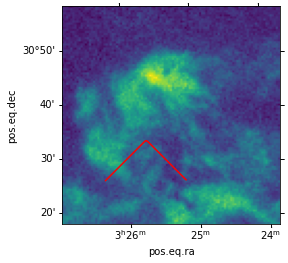

In [9]:
ax = pl.subplot(111, projection=cube.wcs.celestial)
ax.imshow(cube[25].value)
pl.plot(*path.sample_points(spacing=1), color='r')

`path.sample_points` returns the pixel coordinates used for sampling.  `spacing` gives the separation between these points; we finely sampled by picking one-pixel spacing.

We can also use `get_xy` to get the pairs of points we used, but we then have to transpose the data:

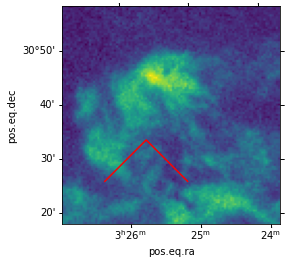

In [10]:
ax = pl.subplot(111, projection=cube.wcs.celestial)
ax.imshow(cube[25].value)
pl.plot(*np.transpose(path.get_xy()), color='r')

We can then extract the pv diagram:

In [11]:
pvdiagram = extract_pv_slice(cube=cube, path=path)
pvdiagram

and plot it.  `pvdiagram` is a `PrimaryHDU` object, so we need to grab the header & data separately:

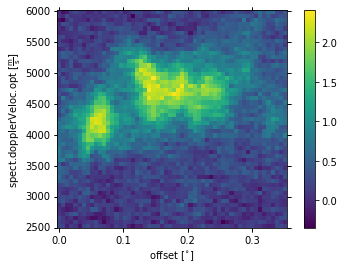

In [12]:
ax = pl.subplot(111, projection=wcs.WCS(pvdiagram.header))
im = ax.imshow(pvdiagram.data)
cb = pl.colorbar(mappable=im)


Changing units is straightforward using [wcsaxes tools](https://docs.astropy.org/en/stable/visualization/wcsaxes/controlling_axes.html):

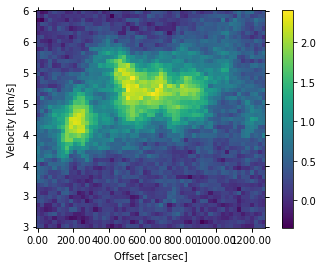

In [13]:
ww = wcs.WCS(pvdiagram.header)

ax = pl.subplot(111, projection=ww)
im = ax.imshow(pvdiagram.data)
cb = pl.colorbar(mappable=im)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcsec]")

We can put all this together:

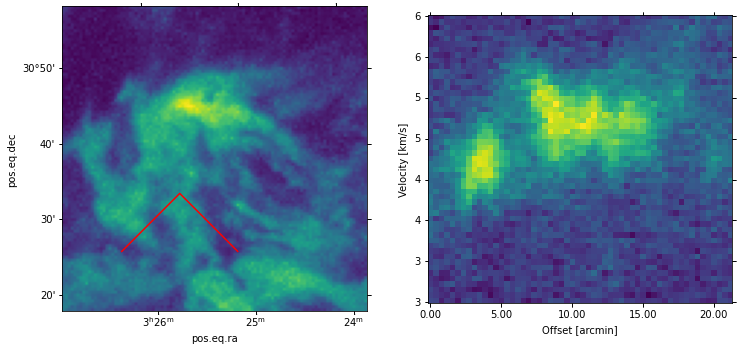

In [14]:
pl.figure(figsize=(12,6))
ax = pl.subplot(121, projection=cube.wcs.celestial)
ax.imshow(cube.max(axis=0).value)
pl.plot(*np.transpose(path.get_xy()), color='r')

ww = wcs.WCS(pvdiagram.header)

ax = pl.subplot(122, projection=ww)
im = ax.imshow(pvdiagram.data)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")

# PV Extraction from Sky Coordinates

We can also make paths using celestial coordinates:

In [15]:
from astropy.coordinates import SkyCoord

In [16]:
skypath = Path(SkyCoord([3.4, 3.43, 3.42]*u.h, [30.5, 30.75, 30.5]*u.deg, frame='fk5'))

We can find the pixel coordinates:

In [17]:
skypath.get_xy(wcs=cube.wcs.celestial)

[(98.19345623536572, 31.0003838618768),
 (35.344283171224106, 70.13082464225408),
 (57.73434827874564, 31.000388317000215)]

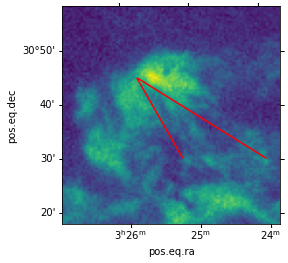

In [18]:
ax = pl.subplot(111, projection=cube.wcs.celestial)
ax.imshow(cube[25].value)
pl.plot(*skypath.sample_points(spacing=1, wcs=cube.wcs.celestial), color='r',)

In [19]:
pvdiagram2 = extract_pv_slice(cube=cube, path=skypath)
pvdiagram2

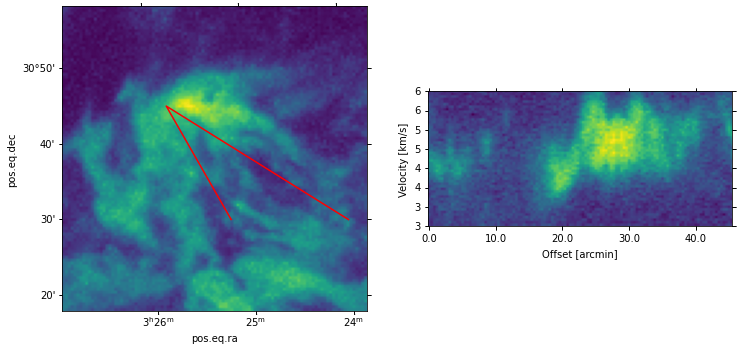

In [20]:
pl.figure(figsize=(12,6))
ax = pl.subplot(121, projection=cube.wcs.celestial)
ax.imshow(cube.max(axis=0).value)
pl.plot(*np.transpose(skypath.get_xy(cube.wcs.celestial)), color='r')

ww = wcs.WCS(pvdiagram2.header)

ax = pl.subplot(122, projection=ww)
im = ax.imshow(pvdiagram2.data)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")

We can also change the aspect ratio:

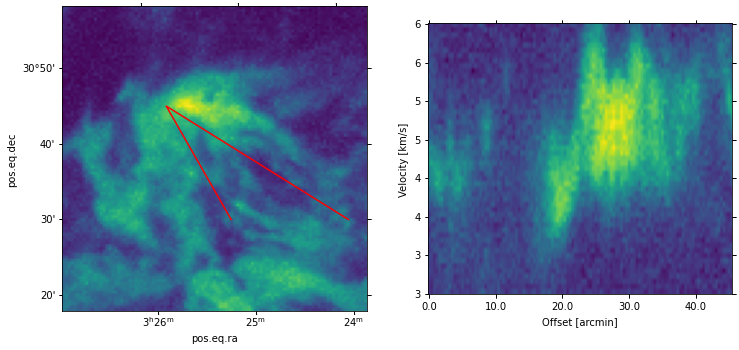

In [21]:
pl.figure(figsize=(12,6))
ax = pl.subplot(121, projection=cube.wcs.celestial)
ax.imshow(cube.max(axis=0).value)
pl.plot(*np.transpose(skypath.get_xy(cube.wcs.celestial)), color='r')

ww = wcs.WCS(pvdiagram2.header)

ax = pl.subplot(122, projection=ww)
im = ax.imshow(pvdiagram2.data)
ax.set_aspect(2)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")

## PV Extraction with Spatial Averaging

`pvextractor` allow you to specify a `width` to average over, which specifies a range around the path to average over:

In [22]:
skypath2 = Path(SkyCoord([3.4, 3.429, 3.42]*u.h, [30.5, 30.75, 30.5]*u.deg, frame='fk5'), width=2*u.arcmin)

In [23]:
pvdiagram3 = extract_pv_slice(cube=cube, path=skypath2)

We can plot this path as a set of patches to show where we averaged.  The default spacing is 1 pixel,so we plot 1-pixel chunks.

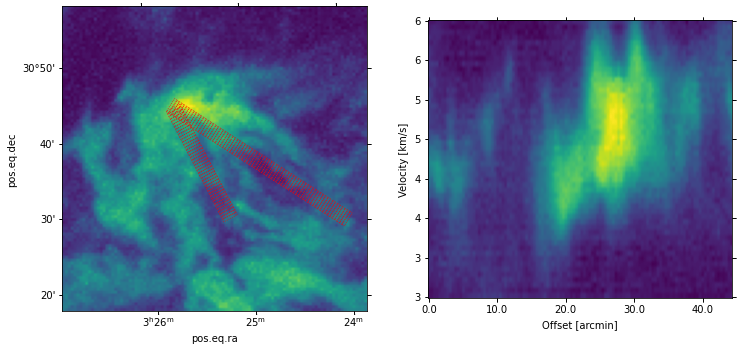

In [24]:
pl.figure(figsize=(12,6))
ax = pl.subplot(121, projection=cube.wcs.celestial)
ax.imshow(cube.max(axis=0).value)
#pl.plot(*np.transpose(skypath2.get_xy(cube.wcs.celestial)), color='r')
for patch in skypath2.to_patches(1, cube.wcs.celestial,
                                 linestyle=':', edgecolor='r',
                                 facecolor='none', linewidth=0.75):
    ax.add_patch(patch)

ww = wcs.WCS(pvdiagram3.header)

ax = pl.subplot(122, projection=ww)
im = ax.imshow(pvdiagram3.data)
ax.set_aspect(2)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")

We can also have more widely spaced chunks.

Note that the spacing given to `extract_pv_slice` affects the shape of the output PV diagram, so we also change the aspect ratio:

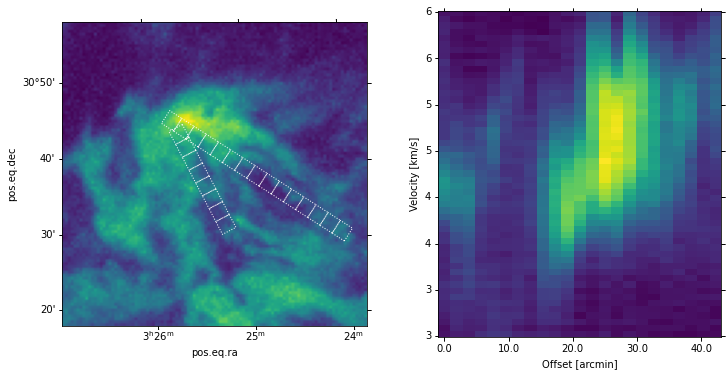

In [25]:
pvdiagram4 = extract_pv_slice(cube=cube, path=skypath2, spacing=5)

pl.figure(figsize=(12,6))
ax = pl.subplot(121, projection=cube.wcs.celestial)
ax.imshow(cube.max(axis=0).value)
#pl.plot(*np.transpose(skypath2.get_xy(cube.wcs.celestial)), color='r')
for patch in skypath2.to_patches(5, cube.wcs.celestial,
                                 linestyle=':', edgecolor='w',
                                 facecolor='none', linewidth=1):
    ax.add_patch(patch)

ww = wcs.WCS(pvdiagram4.header)

ax = pl.subplot(122, projection=ww)
im = ax.imshow(pvdiagram4.data)
ax.set_aspect(0.5)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")